## Importy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics import Precision, Recall, F1Score, ConfusionMatrix, Accuracy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

## Nacitanie dat + Predspracovanie

In [2]:
# Načítanie datasetu z CSV súboru do pandas DataFrame
df = pd.read_csv('../dataset/sales_data.csv')

# Definícia OrdinalEncoder s explicitným poradím pre kategórie v stĺpci 'Age_Group',
# kde vekové skupiny majú prirodzené poradie od najmladších po najstarších.
ordinal_encoder = OrdinalEncoder(categories=[['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']])

# Transformácia stĺpca 'Age_Group' pomocou OrdinalEncoder,
# kde každá veková skupina bude nahradená číselnou hodnotou na základe definovaného poradia.
df['Age_Group_Encoded'] = ordinal_encoder.fit_transform(df[['Age_Group']])

# Inicializácia LabelEncoder na zakódovanie kategórií ako číselných hodnôt.
label_encoder = LabelEncoder()

# Transformácia stĺpca 'Customer_Gender' pomocou LabelEncoder,
# kde každé pohlavie bude zakódované číselnou hodnotou (napr. 0 pre 'Female', 1 pre 'Male').
df['Customer_Gender_Encoded'] = label_encoder.fit_transform(df['Customer_Gender'])

# Transformácia stĺpca 'Country' pomocou LabelEncoder,
# kde každá krajina bude nahradená číselnou hodnotou na základe poradia krajín v datasete.
df['Country_Encoded'] = label_encoder.fit_transform(df['Country'])

# Transformácia stĺpca 'State' pomocou LabelEncoder,
# kde každý štát bude nahradený číselnou hodnotou na základe poradia štátov v datasete.
df['State_Encoded'] = label_encoder.fit_transform(df['State'])

# Transformácia stĺpca 'Product_Category' pomocou LabelEncoder,
# kde každá kategória produktu bude nahradená číselnou hodnotou.
df['Product_Category_Encoded'] = label_encoder.fit_transform(df['Product_Category'])

# Vytvorenie vstupných atribútov X, ktoré obsahujú číselne zakódované hodnoty
# pre rôzne charakteristiky zákazníka a obchodné dáta, ako napríklad vek, pohlavie, krajina, štát, produktová kategória, množstvo objednávok, zisk a tržby.
X = df[['Customer_Age', 'Customer_Gender_Encoded', 'Country_Encoded', 'State_Encoded', 'Product_Category_Encoded', 'Order_Quantity', 'Profit', 'Revenue']]

# Vytvorenie výstupných hodnôt y, ktoré predstavujú zakódovanú vekovú skupinu zákazníka.
y = df['Age_Group_Encoded'].values


## Rozdelenie dat na trenovacie a testovacie

In [3]:
# Rozdelenie dát na tréningovú a testovaciu množinu.
# X (vstupy) a y (cieľové hodnoty) sú rozdelené v pomere 80% na tréning a 20% na testovanie.
# random_state=42 zaisťuje, že rozdelenie bude vždy rovnaké, aby sa zachovala reprodukovateľnosť.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90428, 8), (22608, 8), (90428,), (22608,))

## Normalizacia dat

In [4]:
# Inicializácia StandardScaler, ktorý bude používaný na škálovanie údajov.
# StandardScaler transformuje údaje tak, že každá črta bude mať priemer 0 a smerodajnú odchýlku 1.
scaler = StandardScaler()

# Škálovanie tréningovej množiny pomocou fit_transform, kde scaler najskôr vypočíta
# priemer a odchýlku na základe tréningových dát a následne tieto dáta transformuje.
X_train_scaled = scaler.fit_transform(X_train)

# Škálovanie testovacej množiny pomocou transform, kde sa použijú rovnaké parametre
# (priemer a smerodajná odchýlka) získané z tréningových dát, aby testovacie dáta boli transformované rovnako.
X_test_scaled = scaler.transform(X_test)

## Dataset + Dataloader

In [5]:
# Definícia vlastného datasetu pre vekové skupiny, ktorý dedí od torch.utils.data.Dataset.
class AgeGroupDataset(Dataset):
    def __init__(self, X_features, y_labels):
        # Konverzia vstupných a cieľových dát na tensorové objekty pytorch s príslušným dátovým typom.
        # X_features sa konvertuje na float32, y_labels na long (pre klasifikačné úlohy).
        self.X_features = torch.tensor(X_features, dtype=torch.float32)
        self.y_labels = torch.tensor(y_labels, dtype=torch.long)  # Dátový typ long pre triedenie

    def __len__(self):
        # Vráti počet vzoriek v datasete.
        return len(self.X_features)

    def __getitem__(self, idx):
        # Vráti vstupné a cieľové hodnoty pre daný index idx.
        return self.X_features[idx], self.y_labels[idx]

# Vytvorenie inštancií vlastného datasetu pre tréning a testovanie.
train_dataset = AgeGroupDataset(X_train_scaled, y_train)
test_dataset = AgeGroupDataset(X_test_scaled, y_test)

# Vytvorenie DataLoader pre tréningový dataset s dávkami veľkosti 768 a s náhodným zmiešaním vzoriek.
train_loader = DataLoader(train_dataset, batch_size=860, shuffle=True)

# Vytvorenie DataLoader pre testovací dataset s dávkami veľkosti 768 a bez náhodného zmiešania vzoriek.
test_loader = DataLoader(test_dataset, batch_size=860, shuffle=False)

# Iterácia cez dávky v tréningovom DataLoaderi a výpis rozmerov vstupov a cieľových hodnôt.
# for inputs, targets in train_loader:
#     print("Inputs:", inputs.shape)  # Rozmer tensoru vstupov
#     print("Targets:", targets.shape)  # Rozmer tensoru cieľových hodnôt
#     break  # Skončí po prvom cykle pre výpis rozmerov

## Neuronova siet

In [6]:
class AgeGroupNN(nn.Module):
    def __init__(self, in_features=8, hl1=80, hl2=60, hl3=20, out_features=4):
        # Inicializácia základného triedy nn.Module
        super(AgeGroupNN, self).__init__()
        # Architektúra zostáva nezmenená
        self.fc1 = nn.Linear(in_features, hl1)
        # self.bn1 = nn.BatchNorm1d(128)
        # self.dropout1 = nn.Dropout(0.1)
        
        # self.fc2 = nn.Linear(8, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        # self.dropout2 = nn.Dropout(0.3)

        # Definícia vrstiev neurónovej siete:
        # Prvá skrytá vrstva: lineárna vrstva so vstupnými atribútmi 'in_features' a výstupom 'hl1'
        self.fc3 = nn.Linear(hl1, hl2)
        # Batch Normalization pre skrytú vrstvu 'hl1', normalizuje výstupy z fc3
        self.bn3 = nn.BatchNorm1d(hl2)
        # Dropout pre reguláciu overfittingu (je zakomentovaný)
        self.dropout3 = nn.Dropout(0.2)

        # Druhá skrytá vrstva: lineárna vrstva s 'hl1' vstupmi a 'hl2' výstupmi
        self.fc4 = nn.Linear(hl2, hl3)
        # Batch Normalization pre skrytú vrstvu 'hl2', normalizuje výstupy z fc4
        self.bn4 = nn.BatchNorm1d(hl3)
        # Dropout pre reguláciu overfittingu
        self.dropout4 = nn.Dropout(0.1)

        # Výstupná vrstva: lineárna vrstva s 'hl2' vstupmi a 'out_features' výstupmi
        # 'out_features' predstavuje počet tried vo výstupnej kategórii (4 vekové skupiny)
        self.fc5 = nn.Linear(hl3, out_features)

    def forward(self, x):
        # Predný prechod (forward pass) cez sieť:
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)  # (zakomentované) aplikácia dropout

        # Aplikácia ReLU aktivačnej funkcie a batch normalization pre 'fc3'
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)  # (zakomentované) aplikácia dropout

        # Aplikácia ReLU aktivačnej funkcie a batch normalization pre 'fc4'
        x = torch.relu(self.bn4(self.fc4(x)))
        # Aplikácia dropout pre 'fc4'
        x = self.dropout4(x)

        # Výstup z poslednej lineárnej vrstvy
        x = self.fc5(x)
        
        return x
        
# Inicializácia modelu s preddefinovanými parametrami
model = AgeGroupNN()

# Inicializácia optimalizátora Adam s learning rate 0.0003
# weight_decay pridáva L2 regularizáciu, ktorá penalizuje veľké váhy pre zlepšenie generalizácie modelu
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Inicializácia stratovej funkcie CrossEntropyLoss pre viactriednu klasifikáciu
# Toto bude počítať stratový výstup medzi predikciami modelu a skutočnými triedami
criterion = nn.CrossEntropyLoss()

## Trenovanie modelu

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        # Inicializácia parametrov early stoppingu:
        # patience - počet epoch bez zlepšenia, po ktorých sa zastaví tréning
        # min_delta - minimálny rozdiel, ktorý je považovaný za zlepšenie
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0  # Čítač epoch bez zlepšenia
        self.best_loss = None  # Najlepšia (najnižšia) strata dosiahnutá doteraz
        self.early_stop = False  # Flag, ktorý určuje, či sa má tréning zastaviť

    def __call__(self, val_loss):
        # Metóda sa volá po každej epoche s aktuálnou validačnou stratou
        if self.best_loss is None:
            # Nastavenie prvej hodnoty strata ako najlepšej straty
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            # Ak sa strata zlepšila viac než min_delta, aktualizuje najlepšiu stratu a resetuje čítač
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Ak sa strata nezlepšila, zvýši čítač
            self.counter += 1
            # Ak čítač dosiahne hodnotu patience, aktivuje early stopping
            if self.counter >= self.patience:
                self.early_stop = True


def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    criterion, 
    optimizer, 
    num_epochs = 100,
    patience: int = 10,
    device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    # Inicializácia tréningového procesu
    torch.manual_seed(42)  # Nastavenie náhodného semena pre reprodukovateľnosť
    model.to(device)  # Presunutie modelu na zvolený device (CPU alebo GPU)

    train_losses, train_accuracies, train_precisions, train_confmats = [], [], [], []
    val_losses, val_accuracies, val_precisions, val_confmats = [], [], [], []

    # Inicializácia early stoppingu
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        # Trenovacia fáza
        model.train()  # Nastavenie modelu do tréningového režimu
        train_loss = 0
        all_train_preds, all_train_targets = [], []
        
        # Definovanie metrík
        accuracy = Accuracy(task="multiclass", num_classes=4, average='macro')
        precision = Precision(task="multiclass", num_classes=4, average='macro')
        confmat = ConfusionMatrix(task="multiclass", num_classes=4)
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Presunutie dát na device
            optimizer.zero_grad()  # Nulovanie gradientov pred spätným prechodom
            
            outputs = model(inputs)  # Predikcie modelu
            loss = criterion(outputs, targets)  # Výpočet straty
            
            loss.backward()  # Výpočet gradientov
            optimizer.step()  # Aktualizácia váh

            train_loss += loss.item()
            train_pred = torch.softmax(outputs, dim=1)

            # Uloženie predikcií a skutočných hodnôt
            all_train_preds.append(train_pred)
            all_train_targets.append(targets)

        # Zlúčenie predikcií a skutočných hodnôt do jedného tensoru
        all_train_preds = torch.cat(all_train_preds)
        all_train_targets = torch.cat(all_train_targets)

        # Výpočet priemernej epochovej straty
        epoch_loss = train_loss / len(train_loader)

        train_acc = accuracy(all_train_preds, all_train_targets)
        train_prec = precision(all_train_preds, all_train_targets)
        train_cm = confmat(all_train_preds, all_train_targets)

        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        train_precisions.append(train_prec)
        train_confmats.append(train_cm)

        # Validácia fáza
        model.eval()  # Nastavenie modelu do evaluačného režimu
        val_loss  = 0
        all_val_preds, all_val_targets = [], []

        with torch.inference_mode():  # Deaktivácia gradientov pre inferenciu
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Presunutie dát na device

                outputs = model(inputs)  # Predikcie modelu
                loss = criterion(outputs, targets)  # Výpočet straty

                val_loss += loss.item()
                val_pred = torch.softmax(outputs, 1)

                # Uloženie predikcií a skutočných hodnôt
                all_val_preds.append(val_pred)
                all_val_targets.append(targets)

            # Zlúčenie predikcií a skutočných hodnôt do jedného tensoru
            all_val_preds = torch.cat(all_val_preds)
            all_val_targets = torch.cat(all_val_targets)
        
            # Výpočet priemernej epochovej straty
            epoch_loss = val_loss / len(test_loader)

            val_acc = accuracy(all_val_preds, all_val_targets)
            val_prec = precision(all_val_preds, all_val_targets)
            val_cm = confmat(all_val_preds, all_val_targets)

            val_losses.append(epoch_loss)
            val_accuracies.append(val_acc)
            val_precisions.append(val_prec)
            val_confmats.append(val_cm)
        
        # Výpis výsledkov pre epochu
        print(f"Epoch {epoch+1}/{num_epochs},\n"
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_prec:.4f},\nTrain Conf. Matrix: {train_cm}"
              f"\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_prec:.4f},\nVal Conf. Matrix: {val_cm}")
        print('-' * 100)
        
        # Kontrola, či je potrebné zastaviť tréning
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping activated.")
            break

    return train_losses, train_accuracies, train_precisions, train_confmats, val_losses, val_accuracies, val_precisions, val_confmats

# Trénovanie a validácia modelu
train_losses, train_accuracies, train_precisions, train_confmats, val_losses, val_accuracies, val_precisions, val_confmats = train_and_evaluate(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer
)

Epoch 1/100,
Train Loss: 96.3967, Train Accuracy: 0.5268, Train Precision: 0.5468,
Train Conf. Matrix: tensor([[ 7015,  6919,    95,   193],
        [ 3602, 25187,  1653,   578],
        [  959,  7347, 35153,  1159],
        [    0,    14,   546,     8]])
Val Loss: 16.2470, Val Accuracy: 0.7019, Val Precision: 0.6747,
Val Conf. Matrix: tensor([[ 3588,    18,     0,     0],
        [  962,  6451,   221,     0],
        [    1,   361, 10844,     0],
        [    0,     0,   162,     0]])
----------------------------------------------------------------------------------------------------
Epoch 2/100,
Train Loss: 46.9806, Train Accuracy: 0.6891, Train Precision: 0.9407,
Train Conf. Matrix: tensor([[12242,  1980,     0,     0],
        [ 1258, 28833,   929,     0],
        [    2,  1584, 43032,     0],
        [    8,     0,   559,     1]])
Val Loss: 7.6020, Val Accuracy: 0.7378, Val Precision: 0.7317,
Val Conf. Matrix: tensor([[ 3537,    69,     0,     0],
        [   98,  7501,    35,    

## Zobrazenie vysledkov trenovania a validacie

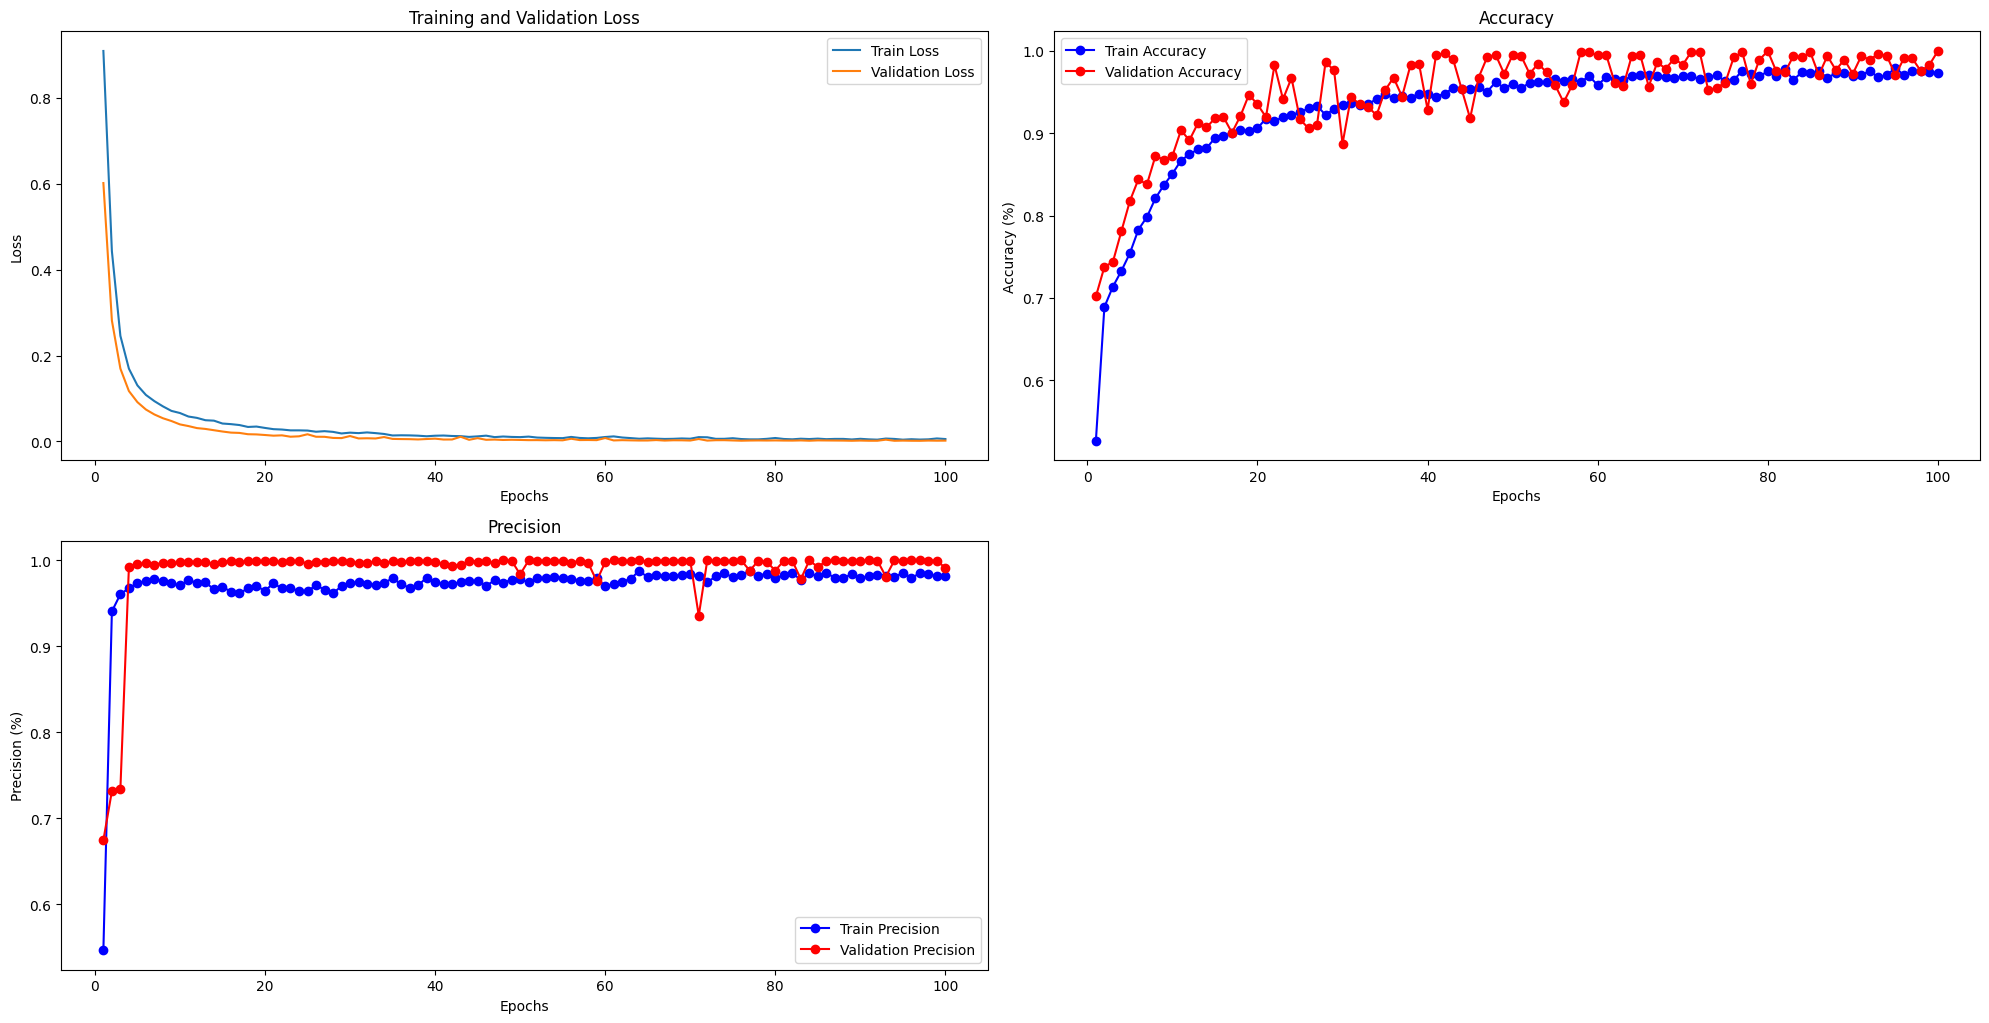

In [8]:

# Plotovanie výsledkov
def plot_results(train_losses, train_accuracies, train_precisions, train_confmats, val_losses, val_accuracies, val_precisions, val_confmats):
    epochs = range(1, len(train_losses) + 1)

    # Nastavenie veľkosti grafu
    plt.figure(figsize=(20, 15))
    
    # Vykreslenie grafu strat
    plt.subplot(3, 2, 1)  # 3 riadky, 2 stĺpce, prvý graf
    plt.plot(epochs, train_losses, label='Train Loss')  # Vykreslenie stratového grafu pre tréning
    plt.plot(epochs, val_losses, label='Validation Loss')  # Vykreslenie stratového grafu pre validáciu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Loss')  # Popis y-ovej osi
    plt.title('Training and Validation Loss')  # Názov grafu
    plt.legend()  # Zobrazenie legendy

    # Graf pre tréningovú a validačnú presnosť
    plt.subplot(3, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Graf pre tréningovú a validačnú presnosť
    plt.subplot(3, 2, 3)
    plt.plot(epochs, train_precisions, 'bo-', label='Train Precision')
    plt.plot(epochs, val_precisions, 'ro-', label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(train_losses, train_accuracies, train_precisions, train_confmats, val_losses, val_accuracies, val_precisions, val_confmats)

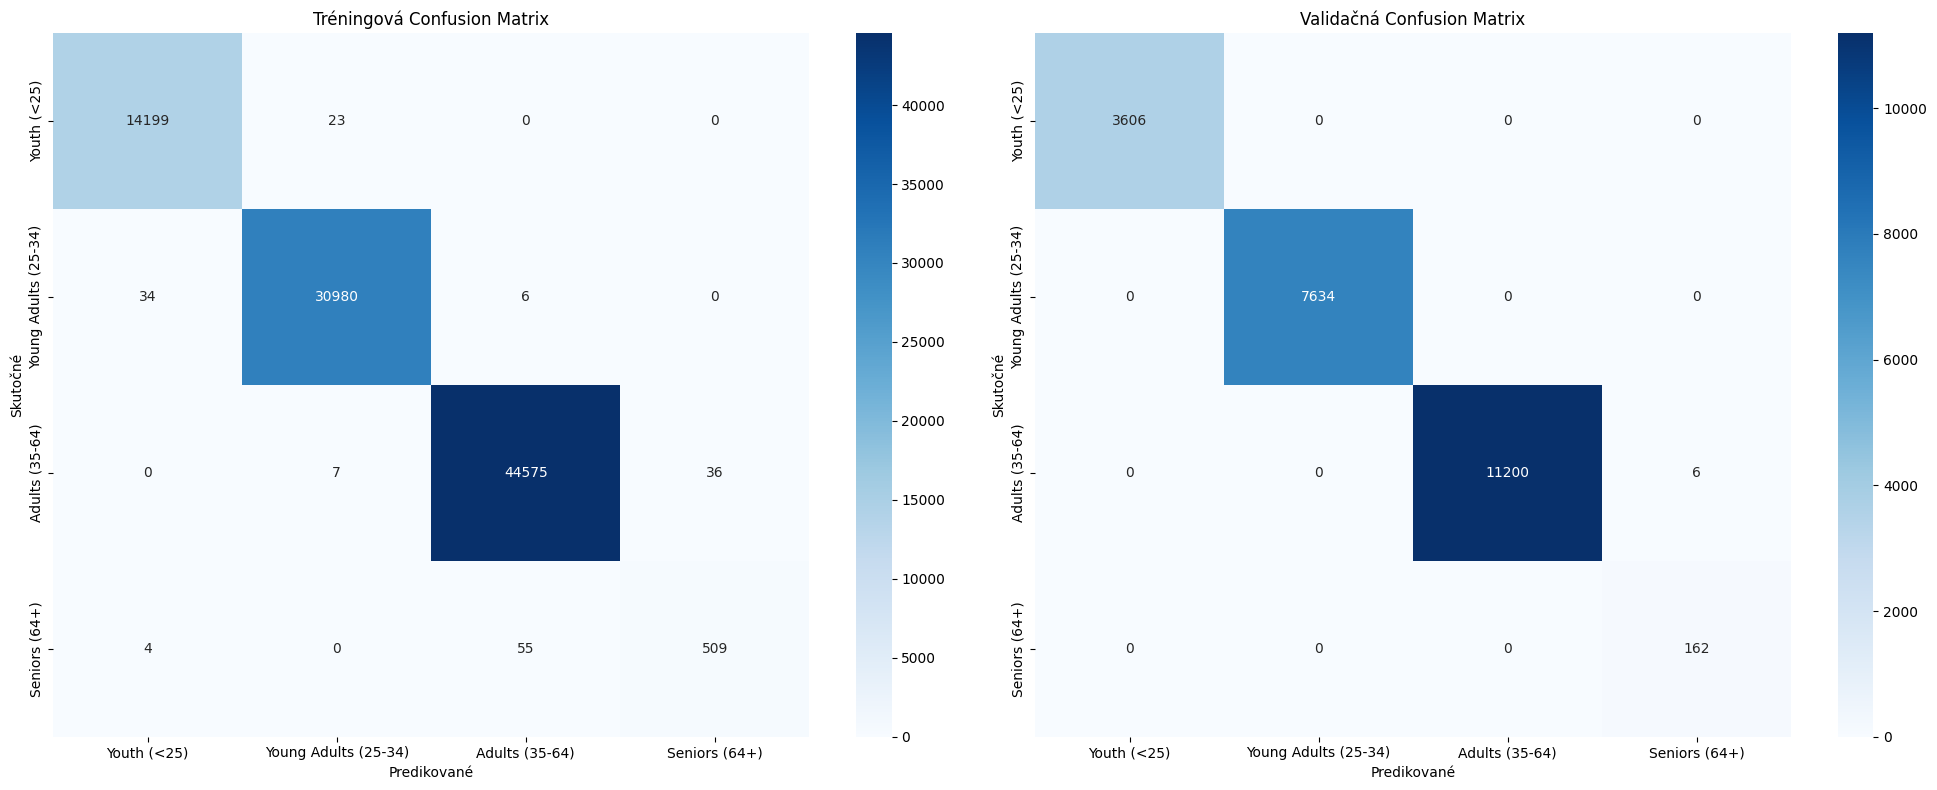

In [9]:

def plot_final_confusion_matrices(train_confmats, val_confmats, class_names, file_name="confusion_matrices.png"):
    # Získame posledné (záverečné) confusion matrices
    final_train_cm = train_confmats[-1]
    final_val_cm = val_confmats[-1]
    
    # Konvertujeme confusion matrices na numpy arrays, ak sú to PyTorch tensory
    train_cm_np = final_train_cm.cpu().numpy() if isinstance(final_train_cm, torch.Tensor) else final_train_cm
    val_cm_np = final_val_cm.cpu().numpy() if isinstance(final_val_cm, torch.Tensor) else final_val_cm
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Tréningová confusion matrix
    sns.heatmap(train_cm_np, annot=True, fmt='d', cmap='Blues', ax=ax1, 
                xticklabels=class_names, yticklabels=class_names)
    ax1.set_title('Tréningová Confusion Matrix')
    ax1.set_xlabel('Predikované')
    ax1.set_ylabel('Skutočné')
    
    # Validačná confusion matrix
    sns.heatmap(val_cm_np, annot=True, fmt='d', cmap='Blues', ax=ax2, 
                xticklabels=class_names, yticklabels=class_names)
    ax2.set_title('Validačná Confusion Matrix')
    ax2.set_xlabel('Predikované')
    ax2.set_ylabel('Skutočné')
    
    plt.tight_layout()
    
    # Uložíme obrázok
    plt.savefig(file_name)
    
    # Zobrazíme obrázok
    plt.show()

# Predpokladáme, že máš 4 triedy
class_names = ['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']

# Volanie funkcie pre vykreslenie záverečného grafu
plot_final_confusion_matrices(train_confmats, val_confmats, class_names, file_name="conf_matrix.png")


## Testovanie predikcii modelu

In [15]:
def generate_input_data(num_samples=10):
    # np.random.seed(42)
    input_data = pd.DataFrame({
        'Customer_Age': np.random.randint(17, 88, num_samples),
        'Customer_Gender_Encoded': np.random.randint(0, 2, num_samples),
        'Country_Encoded': np.random.randint(0, len(df['Country'].unique()) + 1, num_samples), 
        'State_Encoded': np.random.randint(0, len(df['State'].unique()) + 1, num_samples),
        'Product_Category_Encoded': np.random.randint(0, len(df['Product_Category'].unique()) + 1, num_samples), 
        'Order_Quantity': np.random.randint(1, 33, num_samples),
        'Profit': np.random.randint(-30, 15097, num_samples),
        'Revenue': np.random.randint(2, 58075, num_samples),
    })
    return input_data

def predict_age_group(model, input_data, scaler, ordinal_encoder):
    # Uisti sa, že vstup má správny formát (DataFrame, nie numpy array)
    input_scaled = scaler.transform(input_data)  # Scaler už očakáva DataFrame s názvami stĺpcov
    input_tensor = torch.FloatTensor(input_scaled)  # Prekonvertuj na torch tensor
    
    # Prediction
    model.eval()
    with torch.inference_mode():
        output = model(input_tensor)
        predicted = torch.softmax(output, 1).argmax(1)
    
    class_names = ['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']
    for idx, pred in enumerate(predicted):
        print(f'Vzorka {idx+1}: Predikcia: {class_names[pred]}, Pravdepodobnosť: {predicted[idx].item():.2f}')
    
# Generate input data
input_data = generate_input_data()

# Predictions
predictions = predict_age_group(model, input_data, scaler, ordinal_encoder)


Vzorka 1: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 2: Predikcia: Adults (35-64), Pravdepodobnosť: 2.00
Vzorka 3: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 4: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 5: Predikcia: Adults (35-64), Pravdepodobnosť: 2.00
Vzorka 6: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 7: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 8: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 9: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 10: Predikcia: Adults (35-64), Pravdepodobnosť: 2.00


## Ulozenie modelu

In [16]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Nacitanie modelu

In [17]:
new_model = AgeGroupNN()

# Load model state dict 
new_model.load_state_dict(torch.load('models/01_pytorch_workflow_model_0.pth', weights_only=True))
print(f"Loaded model:\n{new_model}")

Loaded model:
AgeGroupNN(
  (fc1): Linear(in_features=8, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=60, bias=True)
  (bn3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=60, out_features=20, bias=True)
  (bn4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=20, out_features=4, bias=True)
)


## Predikcie noveho modelu

In [19]:

# Generate input data
input_data = generate_input_data()
input_data = input_data
input_scaled = scaler.transform(input_data)
input_tensor = torch.FloatTensor(input_scaled)

model.eval()
with torch.inference_mode():
    new_pred = model(input_tensor)
    predicts = torch.softmax(new_pred, 1).argmax(1)

class_names = ['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']
for idx, pred in enumerate(predicts):
    # print(idx+1, pred)
    print(f'Vzorka {idx+1}: Predikcia: {class_names[pred]}, Pravdepodobnosť: {predicts[idx].item():.2f}')


Vzorka 1: Predikcia: Adults (35-64), Pravdepodobnosť: 2.00
Vzorka 2: Predikcia: Youth (<25), Pravdepodobnosť: 0.00
Vzorka 3: Predikcia: Youth (<25), Pravdepodobnosť: 0.00
Vzorka 4: Predikcia: Youth (<25), Pravdepodobnosť: 0.00
Vzorka 5: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 6: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 7: Predikcia: Adults (35-64), Pravdepodobnosť: 2.00
Vzorka 8: Predikcia: Youth (<25), Pravdepodobnosť: 0.00
Vzorka 9: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
Vzorka 10: Predikcia: Seniors (64+), Pravdepodobnosť: 3.00
